# BI Insights and Storytelling

author: Aaron Gillespie  
date: 2025-04-18

## Purpose & Context

This code base is being created in the course of completing module 6 of CSIS 44-643 from NW Missouri University. In this module we are demonstrating an understanding of the types of analysis that are done in real-world business settings. We will treat our hypothetical **smart sales** business as though it were real and needing to understand real things. The data warehouse we'll use is minimal - the one we've built over the past few weeks based in _sqlite_.

Most data explorations in the real world are done with a **purpose**. There's some goal, some *insight* that's being targeted by the data analyst for the benefit of the customer. These goals range is scope, difficulty, and level of abstraction. 

The role of the data analyist is to work from the base of the [Data-Information-Knowledge-Wisdom Pyramid](https://gillespedia.com/Data%2C+Information%2C+Knowledge%2C+Wisdom+Pyramid), synthesizing data into information, and presenting that information in a way that facilitates knowledge transfer.

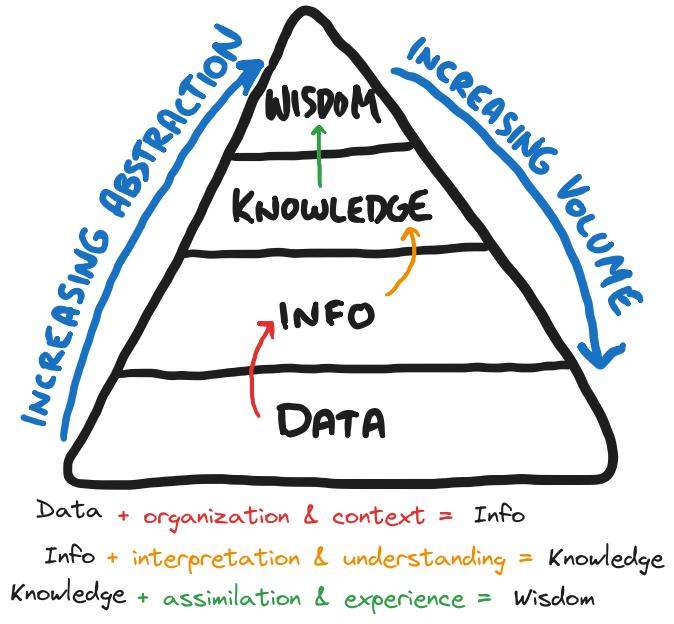

It's then up to leadership to have the wisdom to know what to do with it.

## Section 1. The Business Goal

The goals of business are typically pretty simple, in principle - how can we increase profits while reducing risk. In pursuit of these top-level abstract goals things splinter off and get increasingly complex. The business goal of a data analytics project is rarely aimed at **directly** increasing profits and reducing risk - rather it's aimed at some intermediate step assumed to be on the path toward these higher-level abstract goals.

In the case of our hypothetical "Smart Sales" business - you could imagine the following 3 goals:

1. **In which state(s) are most of our online sales take place?**  
Our online customers are located throughout the United States. If we understood which states were contributing the highest volume of sales, we might recognize potential new markets for brick-and-mortar stores.  

2. **Which stores are most dependent on supplier (X)?**  
If a particular supplier were under contract negotiation, what stores may be most impacted by changing of terms in their supplier agreement?  

3. **Which product's sales benefited most from campaign (X)?**  
If we are paying for advertising for a category of products (e.g. health), we'd like to understand which specific products saw a sales bump as a result of the advertising campaign?  

These are the goals I'll use for this analysis as a proxy for what might exist in a real-world setting. Each goal will list considerations for the analysis to-be done. 

## Section 2. Data Source

To answer these questions I will utilize the previously-prepared Data Warehouse (located in this repo at `data/dw/smart_sales.db`). I will NOT be pre-computing anything, nor will we be utilizing Spark or any other tools aimed at tackling big data-type datasets. Our data simply aren't big enough to warrant such tooling. We will, however, be utilizing the **prepared data**, rather than the raw dataset found in the `data/raw` directory.

## Section 3. Tools

For this work I'll be using a Jupyter Notebook (this one you're looking at now) with Python and some key data analysis libraries including Pandas, Seaborn, Matlibplot, and Sqlite. This choice of tooling partly reflects the nature of the challenge to be solved, and partly the environment in which I'm solving them. I am working from my personal Mac Mini, which has no pre-installed tools like PowerBI or Tableau - however no such tooling is required for this analysis. The aformentioned toolset will suffice. At this point I'm quite comfortable working with these tools.

In [25]:

# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3 as sql

## Section 4. Workflow & Logic

Approaching these on a question-by-question basis:

### 1. **In which state(s) are most of our online sales take place?**  

Here we'll simply look at the state associated with the sales. We'll also consider the date the sale took place in case sales in a given state were high in times past, but have dropped off in recent years. 

*Potential Action:* Establish new frachise locations in state

- Descriptive dimensions: state, year, month
- Numeric metric: total sales amount
- Aggregations: sum and average
- Slicing: by state
- Dicing: by year
- Drilldown: from year to month

### 2. **Which stores are most dependent on supplier (X)?**  

Here we'll join in the Suppliers into the Sales table. In order to make that join, we must also join in the intermediary table `products` which makes the breadcrumb trail possible. 
 
*Potential Action:* diversify store inventory in support of upcoming supplier negotiations to lower dependency on a given supplier

- Descriptive dimensions: store, supplier, year, month
- Numeric metric: total sales amount
- Aggregations: sum
- Slicing: by supplier
- Dicing: by store and year
- Drilldown: from year to month

### 3. **Which product's sales benefited most from campaign (X)?**  

*Potential Action:* understand advertising response for a particular product to inform future ad spend

- Descriptive dimensions: store, supplier, year, month
- Numeric metric: total sales amount
- Aggregations: sum and average
- Slicing: by supplier
- Dicing: by store and year
- Drilldown: from year to month

Since all three of our analysis goals are based on a total Sales Amount ($ figure), it's quite easy to pull **all** the relevant columns to a single data frame for our analysis. This does involve joining the `sales`, `products`, `suppliers`, and `campaigns` tables together - including a join based on a join (sales to products, then products to suppliers) - all of these can be done with a single SQL statement.

In [26]:
# Obtain Data from SQLite Data Warehouse
conn = sql.connect("/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/data/dw/smart_sales.db")  # Resolve to absolute path

query = """
SELECT 
    sales.StoreID, 
    sales.CampaignID, 
    sales.SaleAmount, 
    sales.SaleDate, 
    sales.StateCode, 
    sales.ProductID, 
    products.Supplier, 
    products.ProductName, 
    suppliers.SupplierName, 
    stores.StoreName, 
    campaigns.CampaignName
FROM sales
JOIN products ON sales.ProductID = products.ProductID
JOIN suppliers ON products.Supplier = suppliers.SupplierID
JOIN stores ON sales.StoreID = stores.StoreID
JOIN campaigns ON sales.CampaignID = campaigns.CampaignID
"""

df = pd.read_sql_query(query, conn)
conn.close()
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
df['Year'] = df['SaleDate'].dt.year
df['Month'] = df['SaleDate'].dt.month

# Data Exploration
print("HEAD:")
print(df.head())
print("INFO:")
print(df.info())

HEAD:
   StoreID  CampaignID  SaleAmount   SaleDate StateCode  ProductID  Supplier  \
0      404           0       39.10 2024-01-06        CA        102      1001   
1      403           0       19.78 2024-01-06        TX        105      1004   
2      404           0      335.10 2024-01-16        FL        107      1006   
3      406           0      195.50 2024-01-16        NY        102      1001   
4      405           0      117.30 2024-01-25        PA        102      1001   

  ProductName SupplierName    StoreName CampaignName  Year  Month  
0      hoodie         Bike  Springfield      Podcast  2024      1  
1    football      Balding     Downtown      Podcast  2024      1  
2      jacket      Carhurt  Springfield      Podcast  2024      1  
3      hoodie         Bike         Gary      Podcast  2024      1  
4      hoodie         Bike        Plano      Podcast  2024      1  
INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 13 column

At this point we have a single Pandas Dataframe that can be used to generate visualizations for all three of our analysis goals. 